In [5]:
#Author Alex J. Yang, alexjieyang@outlook.com
import numpy as np
import pandas as pd
import itertools
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm

In [6]:
# calculate CI using bootstrap
def calculateCI(data,method,n):
    m=int(len(data)/10) #take 10% data
    ms=[]
    for j in range(n): #number of samples
        if method=='mean':
                ms.append(np.mean(np.random.choice(data,m)))
        if method=='median':
                ms.append(np.median(np.random.choice(data,m)))
    a,b=[np.percentile(ms,2.5),np.percentile(ms,97.5)]
    return a,b

In [11]:
df.columns

Index(['PaperID', 'Year', 'Reference_Count', 'Citation_Count', 'C_f', 'C5',
       'Team_Size', 'Institution_Count', 'Country_Count', 'Disruption',
       'Atyp_10pct_Z', 'Atyp_Median_Z', 'nAtyp_10pct_Z', 'nAtyp_Median_Z',
       'nAtyp_10pct_Z_p', 'nAtyp_Median_Z_p', 'Patent_Count', 'Patent',
       'Newsfeed_Count', 'Newsfeed', 'Tweet_Count', 'Tweet', 'NCT_Count',
       'NCT', 'NIH_Count', 'NIH', 'NSF_Count', 'NSF', 'PFemale', '#Page',
       'Title Length', 'RaoStirling', 'SimpsonInterdisciplinarity',
       'ShannonInterdisciplinarity', 'AuthorID', 'JournalID', 'FieldID',
       'Fieldname', 'FieldID2', 'FieldNAME2', 'H-index', 'Productivity'],
      dtype='object')

In [8]:
Z_total_10_percent_Sorted = sorted(df['Atyp_10pct_Z'].values)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
find_nearest(Z_total_10_percent_Sorted, -2**1)

pos1 = [find_nearest(Z_total_10_percent_Sorted, -2**(x+1)) for x in range(8)]
pos1 = np.array(pos1)[::-1]
pos2 = [find_nearest(Z_total_10_percent_Sorted, 0)]
pos3 = [find_nearest(Z_total_10_percent_Sorted, 2**(x+1)) for x in range(15)]
pos_p = np.concatenate((pos1, pos2, pos3), axis=None)
pos_p

pct_p = pos_p / len(Z_total_10_percent_Sorted)
pct_p

atyp_x = np.arange(len(pct_p)) + 1
atyp_x

label_x1 = [(x+1) for x in range(8)]
label_x1 = np.array(label_x1)[::-1]
label_x2 = [0]
label_x3 = [(x+1) for x in range(15)]
label_x = np.concatenate((label_x1, label_x2, label_x3), axis=None)
label_x

def myticks(x,pos): 
    if x < 9:
        if x%2 == 0:
            return r""
        return r"$-2^{%d}$" % label_x[pos]
    elif x == 9:
        return r"$0$"
    else:
        if x%2 == 0:
            return r""
        return r"$2^{%d}$" % label_x[pos]

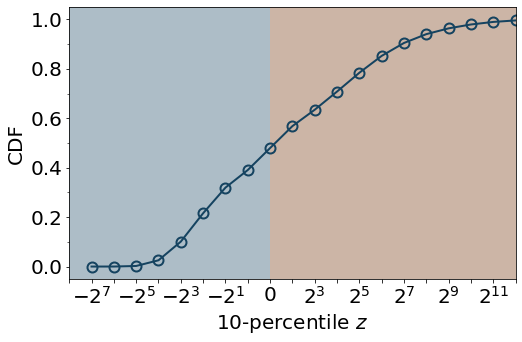

In [9]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(8, 5))
plt.rc('text', usetex=0)
plt.plot(atyp_x, pct_p, 'o-', ms=10, markeredgewidth=2,lw=2, label='$10^{th}$ percentile $Z$-score', markerfacecolor='none',c='#154360')
ax.set_xlim(0,20)
ax.xaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0))
ax.yaxis.set_minor_locator(ticker.IndexLocator(base=0.1, offset=0))
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

ax.set_xlabel('10-percentile $z$', fontsize = 20)
ax.set_ylabel('CDF', fontsize = 20)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(myticks))
ax.axvspan(0,9, facecolor='#154360', alpha=0.35)
ax.axvspan(9,20, facecolor='#6E2C00', alpha=0.35)

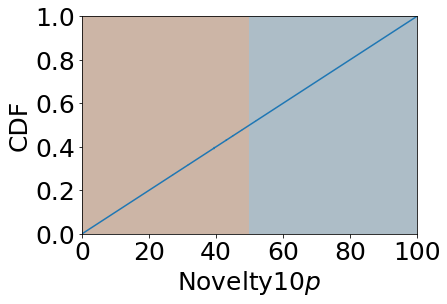

In [16]:
f, ax = plt.subplots(figsize=(6, 4))
# Plot the CdfP curve
sns.ecdfplot(data=df['nAtyp_10pct_Z_p'])
# ax.set_yscale("log")

plt.xlim((0,100))

plt.xlabel('Novelty$10p$',fontsize = 25)
plt.ylabel('CDF',fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

# Show the plot
ax.axvspan(0,50, facecolor='#6E2C00', alpha=0.35)
ax.axvspan(50,100, facecolor='#154360', alpha=0.35)

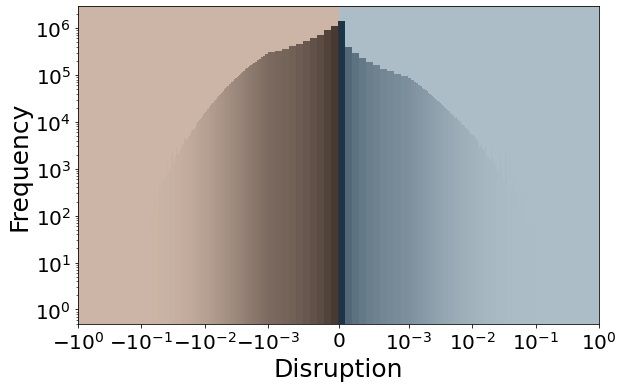

In [15]:
D = df['Disruption'].values
nbins=20000

fig = plt.figure(figsize=(8, 5),facecolor='white')
ax = fig.add_subplot(111)

N, bins, patches = ax.hist(D, bins=nbins,edgecolor='white', linewidth=0)
LN=np.log(max(N))

delta=bins[1]-bins[0]
peaks=set([j/i for i in range(1,100) for j in range(1,i)]+\
[-j/i for i in range(1,100) for j in range(1,i)]) 
ys=dict((i,(patches[i-1]._height+patches[i+1]._height)*0.5) \
        for i in range(1,len(N)-2)) #smooth color

for i,z in zip(range(0,nbins),bins):
    if patches[i]._height>0: # only plot patches with values
        r=(np.log(patches[i]._height)/LN)**5 # transparency scales to y values
        for p in peaks:
            if z<p<z+delta and 0<i<len(N):
                r=(np.log(ys[i]+1)/LN)**5 # disruption fraction
        patches[i].set_alpha(r)
        patches[i].set_facecolor(color='#212F3D')

#
plt.yscale('log')
plt.xscale('symlog', linthresh = .001)
plt.tight_layout()
plt.xlabel('Disruption',fontsize=25)
plt.ylabel('Frequency',fontsize=25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
#plt.savefig(path+'Fig1b.pdf')
ax.set_xlim(-1,1)
ax.axvspan(-1,0, facecolor='#6E2C00', alpha=0.35)
ax.axvspan(0,1, facecolor='#154360', alpha=0.35)